In [14]:
from IPython.display import clear_output
%pip install rouge_score -q
%pip install deep-phonemizer -q
clear_output()

Imports

In [1]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce MX330


Hyperparameters

In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

HELPER FUNCTIONS

There are Two helper functions:
1. The first function is to build special tokens while tokenizing the captions 
2. The second function is used to compute the metrics as we are working with Transformers

In [4]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [5]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


C:\Users\KIIT\AppData\Local\Temp\ipykernel_16884\3017898321.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")
c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Dataset


Feature Extractor and Tokenizer:

1. The Feature extractor is loaded using ViTFeatureExtractor
2. The tokenizer for GPT2 is loaded using the AutoTokenizer

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Transforms and dataframe :

The Transformations used are -

1. Resizing the image to (224,224)
2. Normalizing the image
3. Converting the image to Tensor

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("C:\\Users\\KIIT\\Desktop\\Major Project\\flickr8k\\captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Dataset Class

In [8]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        

Train and validation of dataset:

In [9]:
train_dataset = ImgDataset(train_df, root_dir = "C:/Users/KIIT/Desktop/Major Project/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "C:/Users/KIIT/Desktop/Major Project/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

Model Building

ENCODER:-

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3><span style = "color:#00000;font-family:'Times New Roman'">The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</span></font>

DECODER:-
<br> 

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3><span style = "color:#00000;font-family:'Times New Roman'">GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</span></font>
    
<font size = 3><span style = "color:#00000;font-family:'Times New Roman'">This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</span></font>
    

Model Initialization :

In [10]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.

In [11]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

TRAINING:-

Training Arguments :

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training using Seq2SeqTrainer :

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

trainer.train()

In [ ]:
trainer.save_model('Image_captioning_model')

Saving model checkpoint to Image_captioning_model
Configuration saved in Image_captioning_model/config.json
Model weights saved in Image_captioning_model/pytorch_model.bin
Feature extractor saved in Image_captioning_model/preprocessor_config.json


In [17]:
#load the model

model = VisionEncoderDecoderModel.from_pretrained('C:\\Users\\KIIT\\Desktop\\Major Project\\working\\image_captioning_model')

Predictions:

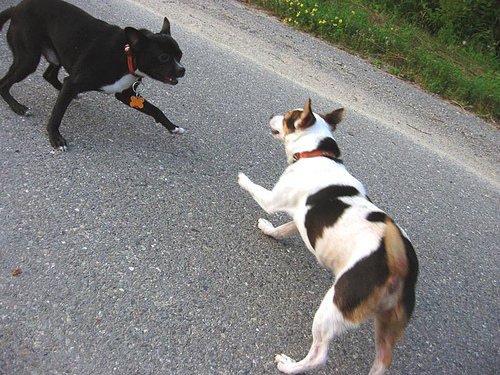

In [18]:
img =  Image.open("C:/Users/KIIT/Desktop/Major Project/flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [22]:
# Preprocess the image and extract features
inputs = feature_extractor(img, return_tensors="pt")

# Move inputs to the appropriate device (CPU or GPU)
inputs = inputs.to('cuda')

# Generate caption
generated_ids = model.generate(**inputs)

# Decode the generated caption
generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Print the first 85 characters of the generated caption in cyan color
print('\033[96m' + generated_caption[:85] + '\033[0m')

A black dog and a brown dog are running on the sidewalk. The black dog is chasing the


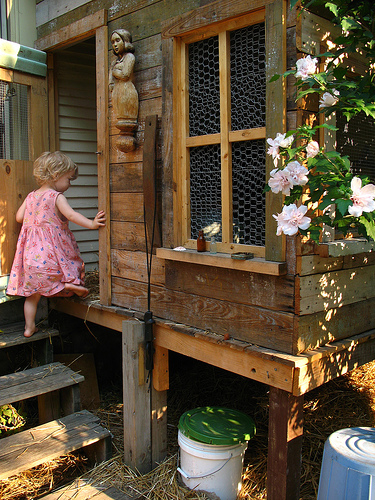

In [26]:
img =  Image.open("C:/Users/KIIT/Desktop/Major Project/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [27]:
# Preprocess the image and extract features
inputs = feature_extractor(img, return_tensors="pt")

# Move inputs to the appropriate device (CPU or GPU)
inputs = inputs.to('cuda')

# Generate caption
generated_ids = model.generate(**inputs)

# Decode the generated caption
generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Print the first 85 characters of the generated caption in cyan color
print('\033[96m' + generated_caption[:85] + '\033[0m')

A little girl in a pink dress is sitting on a wooden staircase. She is looking out th


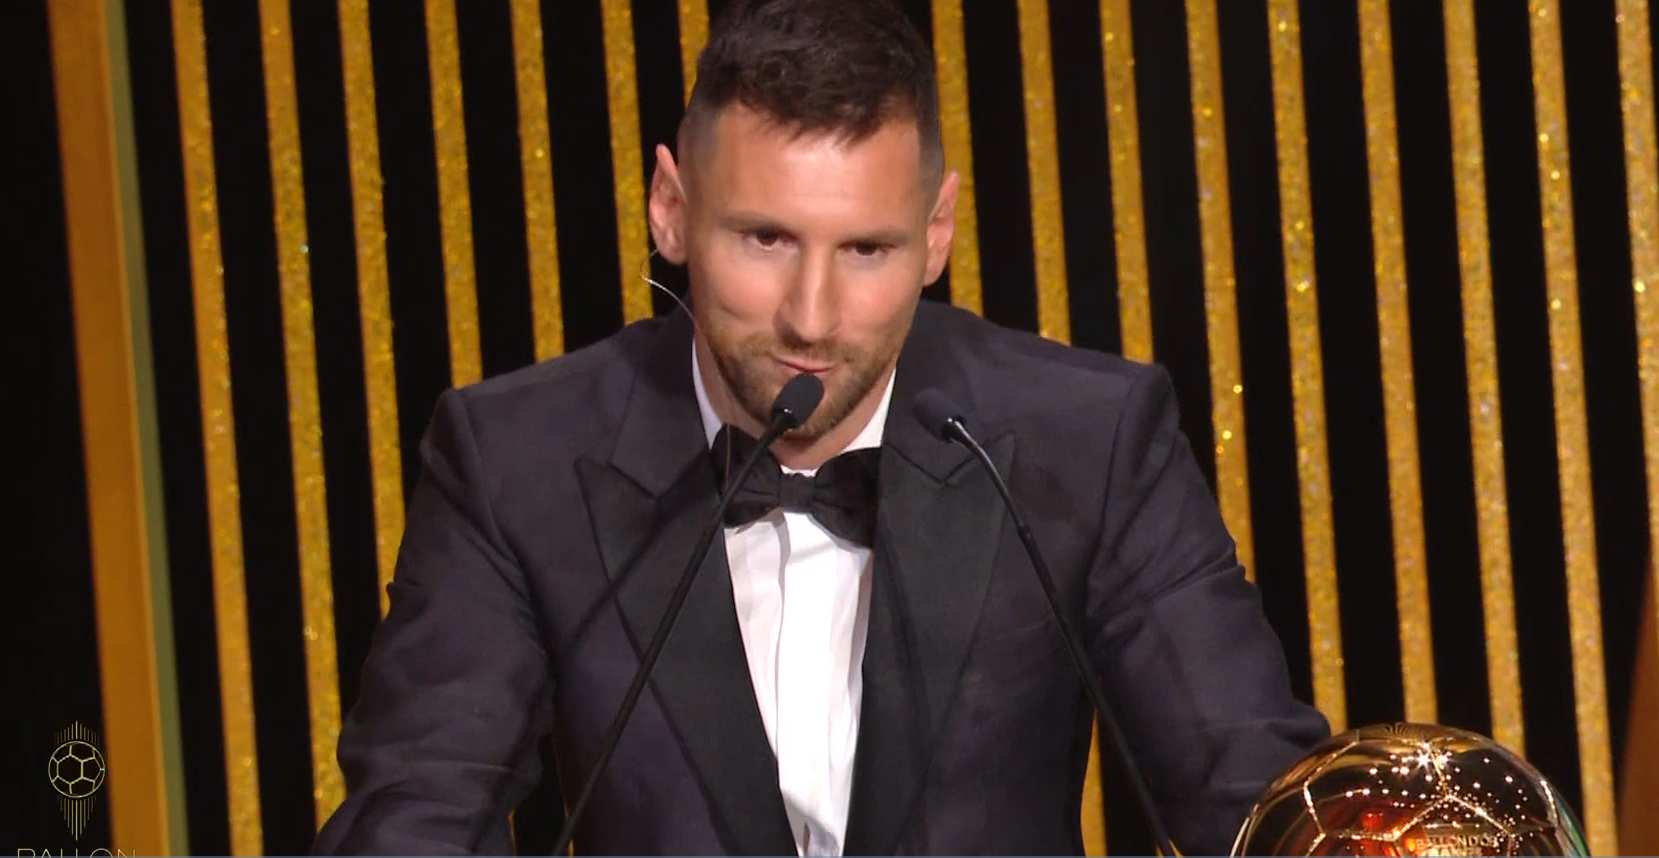

In [28]:
#pick a random image from the pc

img = Image.open("C:/Users/KIIT/Desktop/Photu/D'or.png").convert("RGB")
img

In [29]:
# Preprocess the image and extract features
inputs = feature_extractor(img, return_tensors="pt")

# Move inputs to the appropriate device (CPU or GPU)
inputs = inputs.to('cuda')

# Generate caption
generated_ids = model.generate(**inputs)

# Decode the generated caption
generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Print the first 85 characters of the generated caption in cyan color
print('\033[96m' + generated_caption[:85] + '\033[0m')

A man dressed in a suit and tie is sitting at a table with a drink in his hand. Anoth
